<a href="https://colab.research.google.com/github/Vaibhav3M/CIFAR-10-Image-classification/blob/master/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#using LeNet Architecture

In [5]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

#use of GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
transform_training = transforms.Compose([transforms.Resize(32,32),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.RandomRotation(10),
                                         transforms.RandomAffine(0, shear = 10, scale = (0.8,1.2)),
                                         transforms.ColorJitter(brightness = 0.2, contrast=0.1, saturation = 0.2),
                                         transforms.Resize((32,32)), 
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5,),(0.5,))
                                        ])

transform = transforms.Compose([transforms.Resize((32,32)), 
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))
                               ])

training_dataset = datasets.CIFAR10(root = './data', train = True, download = True, transform = transform_training)
test_dataset = datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)

training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 100, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,batch_size = 100, shuffle = False)

0it [00:00, ?it/s]

100%|█████████▉| 170074112/170498071 [00:31<00:00, 5778141.16it/s]

Files already downloaded and verified


In [0]:
def img_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image


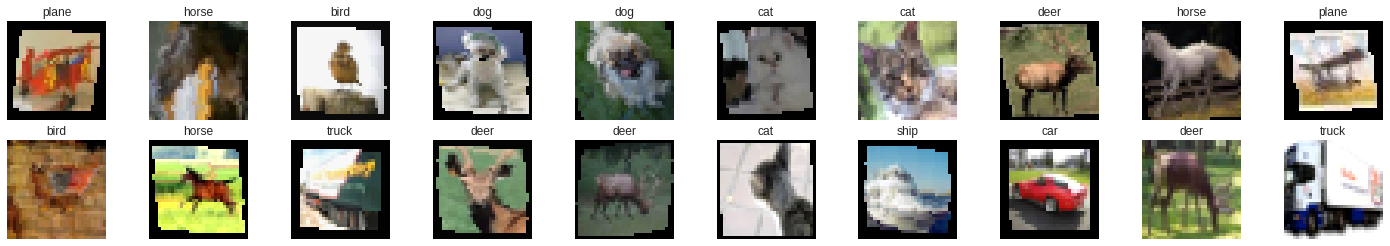

In [11]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (25,4))
classes = ("plane", "car","bird","cat","deer","dog","frog","horse","ship", "truck")

for idx in np.arange(20):
  ax = fig.add_subplot(2,10,idx+1, xticks = [], yticks = [])
  plt.imshow(img_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

  


In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding = 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding = 1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding = 1)
    self.fc1 = nn.Linear(4*4*64, 500)
    self.fc2 = nn.Linear(500 ,10)
    self.dropout1 = nn.Dropout(0.5)
    
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64)    
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [22]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5)
)

In [0]:
criterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [24]:
epochs = 15
running_loss_history = []
running_correct_history = []

val_running_loss_history = []
val_running_correct_history = []

for i in range(epochs):
  
  val_running_loss , val_running_correct ,running_loss, running_correct = 0.0, 0.0, 0.0, 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterian(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item() 
   
    _,preds = torch.max(outputs,1)
    running_correct += torch.sum(preds == labels.data)
  else:
    with torch.no_grad():
          for val_inputs,val_labels in test_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterian(val_outputs,val_labels) 
          
            val_running_loss += val_loss.item() 
            _,val_preds = torch.max(val_outputs,1)
            val_running_correct += torch.sum(val_preds == val_labels.data)
        
    
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_correct.float()/len(training_loader)
    running_loss_history.append(epoch_loss)
    running_correct_history.append(running_correct)
    print("epoch: " , (i+1) )
    print("Training Loss is {:.4f} accuracy is {:.4f}".format(epoch_loss,epoch_acc.item()))
    
    val_epoch_loss = val_running_loss/len(test_loader)
    val_epoch_acc = val_running_correct.float()/len(test_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_correct_history.append(val_running_correct)
    print("Test Loss is {:.4f} accuracy is {:.4f}".format(val_epoch_loss,val_epoch_acc.item()))
    
    

epoch:  1
Training Loss is 1.6902 accuracy is 37.8300
Test Loss is 1.3728 accuracy is 49.8700
epoch:  2
Training Loss is 1.3860 accuracy is 49.6640
Test Loss is 1.2141 accuracy is 56.1300
epoch:  3
Training Loss is 1.2547 accuracy is 55.0840
Test Loss is 1.1158 accuracy is 60.2400
epoch:  4
Training Loss is 1.1673 accuracy is 58.1120
Test Loss is 1.0589 accuracy is 62.1300
epoch:  5
Training Loss is 1.0996 accuracy is 60.9900
Test Loss is 1.0313 accuracy is 62.8400
epoch:  6
Training Loss is 1.0490 accuracy is 63.0140
Test Loss is 0.9852 accuracy is 65.5100
epoch:  7
Training Loss is 1.0076 accuracy is 64.3560
Test Loss is 0.9081 accuracy is 68.5500
epoch:  8
Training Loss is 0.9748 accuracy is 65.5820
Test Loss is 0.8791 accuracy is 69.2100
epoch:  9
Training Loss is 0.9357 accuracy is 67.0780
Test Loss is 0.8647 accuracy is 70.3600
epoch:  10
Training Loss is 0.9156 accuracy is 67.8480
Test Loss is 0.8438 accuracy is 70.8100
epoch:  11
Training Loss is 0.9021 accuracy is 68.4880
Test

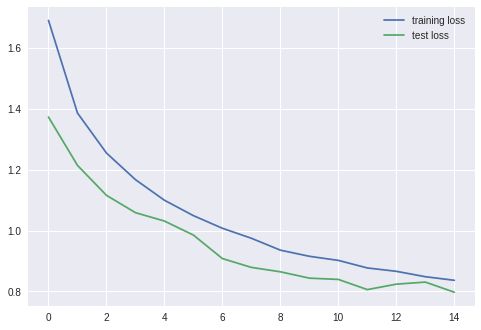

In [25]:
plt.plot(running_loss_history, label = "training loss")
plt.plot(val_running_loss_history, label = "test loss")
plt.legend()

In [0]:
#testing the model

In [0]:
#importing image
import requests
from PIL import Image
import PIL.ImageOps
url = "https://i.pinimg.com/originals/77/55/d8/7755d8bbdd1c5cf5d75a8b0fc58cac94.jpg"
response = requests.get(url, stream = True)
img = Image.open(response.raw)

In [0]:
img = transform(img)

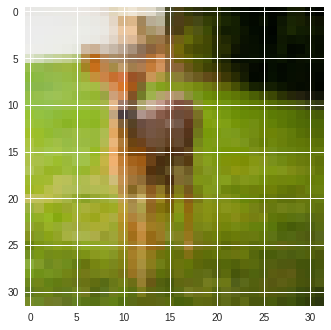

In [37]:
plt.imshow(img_convert(img))

In [38]:
input_val = img.to(device).unsqueeze(0)
output = model(input_val)
_, pred = torch.max(output,1)
print(classes[pred.item()])

deer


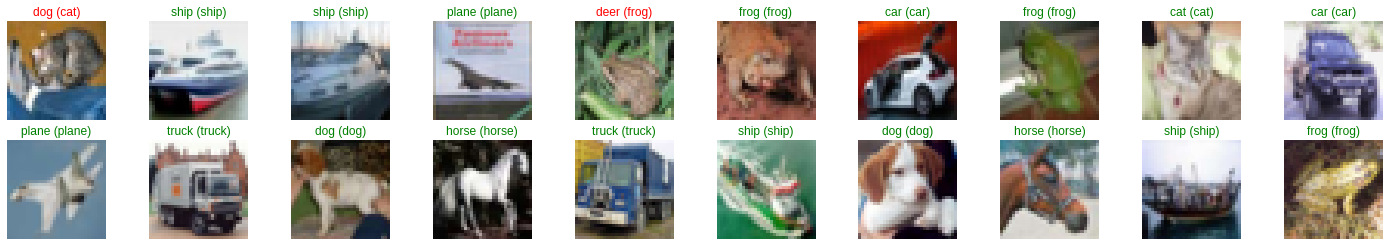

In [39]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(img_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))